In [2]:
import pickle, os
import sys
from utils import QS, sample_apply, BS, cdf_apply
import pandas as pd
import numpy as np
import CRPS.CRPS as pscore
import matplotlib.pyplot as plt
from correlation import plot_qq_for_all_stations

from analysis_seasonal import *

from sklearn.calibration import calibration_curve

%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append('CONFIG_files/')

## Import model predictions

In [4]:
import CONFIG_eLLOiWHFRq as CONFIG

CONFIG.REGION

'COMBINED'

In [5]:
run_prefix = 'eLLOiWHFRq'

with open(f'/data/hpcdata/users/marron31/_experiments/{run_prefix}/predictions.pkl', 'rb') as handle:
    predictions = pickle.load(handle)

In [6]:
def delete_uncomplete_runs_from_predictions(predictions, CONFIG):
    for k,run in predictions.items():
#         print(k, run.keys())
#         print(len(CONFIG.params['k']))
        if len(run.keys()) < len(CONFIG.params['k']):
            del run
            print(f'deleted run {k}')

In [7]:
delete_uncomplete_runs_from_predictions(predictions, CONFIG)

In [8]:
def create_k_all_predictions(predictions, CONFIG):
    # Create predictions for k_all
    for run in predictions.keys():
        for i in range(len(CONFIG.params['k'])):
            predictions[run][f'k{i}']['k_fold'] = i
            if i == 0:
                predictions[run]['k_all'] = predictions[run][f'k{i}']
            else:
                predictions[run]['k_all'] = pd.concat([predictions[run]['k_all'],predictions[run][f'k{i}']])

In [9]:
create_k_all_predictions(predictions, CONFIG)

## CRPS

In [450]:
import CRPS.CRPS as pscore

In [467]:
%%time 
# import scipy

# pi = df['pi']
# alpha = df['alpha']
# beta = df['beta']
# perc = df[series]

def CRPS_apply(df):
    x = scipy.stats.gamma.ppf(q=np.linspace(0,1,100)[1:-1], a=df['alpha'], loc=0, scale=1/df['beta'])
    crps,fcrps,acrps = pscore(x, df['Prec']).compute()
    return crps

def CRPS_clim_apply(df, x):
    crps,fcrps,acrps = pscore(x, df['Prec']).compute()
    return crps

# crps = predictions['MLP_[10]_bgmm_B=128_D=0']['k_all'][:10000].apply(CRPS_apply, axis=1)  
# crps1 = predictions['VGLM_[]_bgmm_B=128_D=0']['k_all'][:10000].apply(CRPS_apply, axis=1)  
# plt.hist(x)
# print(crps)

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 12.6 µs


In [478]:
def compute_CRPS(predictions): 
    for k,v in predictions.items():
        
        p = v['k_all']
        
#         p['CRPS_clim'] = p.apply(CRPS_clim_apply, axis=1, args=(p['Prec'].to_numpy()))
#         print(f'Completed climatology for {run}')
        p['CRPS_mod'] = p.apply(CRPS_apply, axis=1)
        print(f'Completed model for {k}')

In [479]:
compute_CRPS(predictions)

Completed model for VGLM_[]_bgmm_B=128_D=0
Completed model for MLP_[10]_bgmm_B=128_D=0
Completed model for MLP_[50, 50]_bgmm_B=128_D=0


## Reliability diagrams

In [14]:
threshold = 10

simulated = 'precip_norris'
observed = 'Prec'

#y_pred = (predictions['MLP_[10]_bgmm_B=128_D=0']['k_all'][simulated]>threshold).astype('int')

if threshold == 0:
    y_pred = 1 - predictions['MLP_[10]_bgmm_B=128_D=0']['k_all']['pi']
else:
    y_pred = 1 - predictions['MLP_[10]_bgmm_B=128_D=0']['k_all'].apply(cdf_apply, axis=1, args=('bgmm','10000',threshold))

y_true = (predictions['MLP_[10]_bgmm_B=128_D=0']['k_all'][observed]>threshold).astype('int')

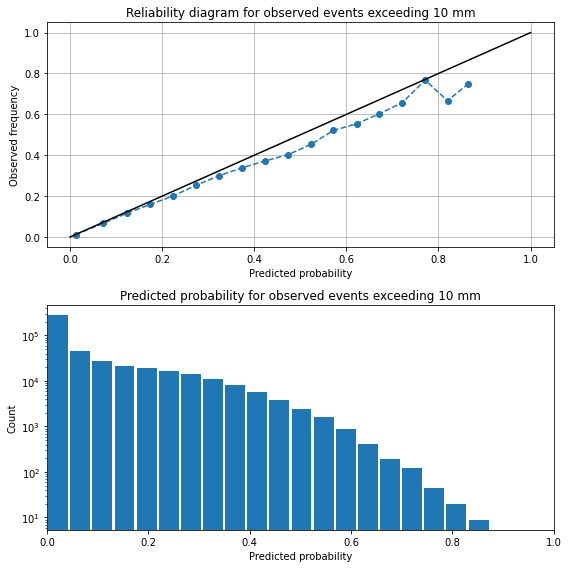

In [15]:
num_bins = 20

prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=num_bins, strategy='uniform')

# print(prob_true)
# print(prob_pred)

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

ax1.plot(prob_pred, prob_true, 'o--')
ax1.plot([0,1],[0,1],'k')

ax1.set_xlabel('Predicted probability')
ax1.set_ylabel('Observed frequency')
ax1.set_xlim(-0.05,1.05)
ax1.set_ylim(-0.05,1.05)
ax1.grid()

ax2.hist(y_pred, bins=num_bins, rwidth=0.9)
ax2.set_yscale('log')
ax2.set_xlim(0,1)
ax2.set_ylabel('Count')
ax2.set_xlabel('Predicted probability')
ax1.set_title(f'Reliability diagram for observed events exceeding {threshold} mm')
ax2.set_title(f'Predicted probability for observed events exceeding {threshold} mm')
plt.tight_layout()
plt.show()

## Brier Score

In [486]:
def brier_score_routine(predictions, simulated='precip_norris', observed='Prec', threshold=0, print_table = True, export_df = False):
    
    headers = ['Model', 'Pred', 'Sim', 'Clim', 'Rand', 'BSS_sim', 'BSS_clim', 'BSSsim_clim']
    table = []
    df_stations = pd.DataFrame()
    
    print(f'Threshold: {threshold:.0f} mm')
#     print(f"{'Model' :<40} {'Pred':<8} {'Sim':<8} {'Clim':<8} {'Rand':<8} {'BSS':<8} {'BSSclim':<8} {'BSSref':<8}")
    
    for idx, run in enumerate(predictions.keys()):

        predictions[run]['k_all']['simulated_occurrence'] = (predictions[run]['k_all'][simulated]>threshold).astype('int')
        predictions[run]['k_all']['observed_occurrence'] = (predictions[run]['k_all'][observed]>threshold).astype('int')
        predictions[run]['k_all']['climatology_occurrence'] = predictions[run]['k_all']['observed_occurrence'].mean()
        predictions[run]['k_all']['climatology_occurrence_station'] = predictions[run]['k_all'].groupby('Station')['observed_occurrence'].transform('mean')    
        predictions[run]['k_all']['random_occurrence'] = np.random.random(len(predictions[run]['k_all']))
        
        if threshold == 0:
            predictions[run]['k_all']['modelled_occurrence'] = 1 - predictions[run]['k_all']['pi']
        else:
            predictions[run]['k_all']['modelled_occurrence'] = 1 - predictions[run]['k_all'].apply(cdf_apply, axis=1, args=('bgmm','10000',threshold))
            
        predictions[run]['k_all'][f'BS_rand_{threshold}'] = predictions[run]['k_all'].apply(BS, axis=1, args=('random_occurrence','Prec',threshold))
        predictions[run]['k_all'][f'BS_sim_{threshold}'] = predictions[run]['k_all'].apply(BS, axis=1, args=('simulated_occurrence','Prec',threshold))
        predictions[run]['k_all'][f'BS_obs_{threshold}'] = predictions[run]['k_all'].apply(BS, axis=1, args=('climatology_occurrence','Prec',threshold))
        predictions[run]['k_all'][f'BS_obs_station_{threshold}'] = predictions[run]['k_all'].apply(BS, axis=1, args=('climatology_occurrence_station','Prec',threshold))

        ref_rand = predictions[run]['k_all'][f'BS_rand_{threshold}'].mean()
        ref_sim = predictions[run]['k_all'][f'BS_sim_{threshold}'].mean()
        ref_clim = predictions[run]['k_all'][f'BS_obs_{threshold}'].mean()
        ref_clim_station = predictions[run]['k_all'][f'BS_obs_station_{threshold}'].mean()
            
        predictions[run]['k_all'][f'BS_{threshold}'] = predictions[run]['k_all'].apply(BS, axis=1, args=('modelled_occurrence','Prec',threshold))
        
        pred = predictions[run]['k_all'][f'BS_{threshold}'].mean()
#         print(f"{run :<40} {pred:<8.3f} {ref_sim:<8.3f} {ref_clim:<8.3f} {ref_rand:<8.3f} {1-pred/ref_sim:<8.3f} {1-pred/ref_clim:<8.3f} {1-ref_sim/ref_clim:<8.3f}")
                        
        table.append([run, f'{pred:.3f}', f'{ref_sim:.3f}', f'{ref_clim:.3f}', f'{ref_rand:.3f}', f'{1-pred/ref_sim:.3f}', f'{1-pred/ref_clim:.3f}', f'{1-ref_sim/ref_clim:.3f}'])
                        
        BS_station = predictions[run]['k_all'].groupby('Station').mean()
        BS_station['BSS_clim'] = 1 - BS_station[f'BS_{threshold}'] / BS_station[f'BS_obs_station_{threshold}']
        BS_station['BSS'] = 1 - BS_station[f'BS_{threshold}'] / BS_station[f'BS_sim_{threshold}']
        
        # print(BS_station[[f'BS_{threshold}', f'BS_sim_{threshold}', f'BS_obs_station_{threshold}', 'BSS', 'BSS_clim']])
        BS_station_sel = BS_station[[f'BS_{threshold}', f'BS_sim_{threshold}', f'BS_obs_station_{threshold}', 'BSS', 'BSS_clim']].copy()
        BS_station_sel.to_csv(f'/data/hpcdata/users/marron31/_exports/{run_prefix}_{run}_Q{threshold}.csv')
        BS_station_sel = BS_station_sel.add_prefix(run)
        df_stations = pd.concat([df_stations, BS_station_sel], axis=1)
        
    if export_df: pd.DataFrame(table,columns=headers).to_csv('/data/hpcdata/users/marron31/_exports/example.csv')
                   
    if print_table: print(tabulate(table, headers, tablefmt='grid'))
    
    return df_stations

In [483]:
print("-------------------- BRIER SCORE AND BRIER SKILL SCORE -------------------")

BS_0 = brier_score_routine(predictions, threshold=0)
BS_10 = brier_score_routine(predictions, threshold=10)
# BS_20 = brier_score_routine(predictions, threshold=30)
# BS_50 = brier_score_routine(predictions, threshold=50)
# BS_100 = brier_score_routine(predictions, threshold=100)

-------------------- BRIER SCORE AND BRIER SKILL SCORE -------------------
Threshold: 0 mm
Model                                    Pred     Sim      Clim     Rand     BSS      BSSclim  BSSref  
VGLM_[]_bgmm_B=128_D=0                   0.141    0.297    0.179    0.334    0.525    0.212    -0.657  
MLP_[10]_bgmm_B=128_D=0                  0.136    0.297    0.179    0.333    0.543    0.242    -0.657  
MLP_[50, 50]_bgmm_B=128_D=0              0.133    0.297    0.179    0.333    0.552    0.258    -0.657  
Model                          Pred    Sim    Clim    Rand    BSS_sim    BSS_clim    BSSsim_clim
---------------------------  ------  -----  ------  ------  ---------  ----------  -------------
VGLM_[]_bgmm_B=128_D=0        0.141  0.297   0.179   0.334      0.525       0.578          0.112
MLP_[10]_bgmm_B=128_D=0       0.136  0.297   0.179   0.333      0.543       0.593          0.11
MLP_[50, 50]_bgmm_B=128_D=0   0.133  0.297   0.179   0.333      0.552       0.601          0.11
Threshold:

In [ ]:
BS_30 = brier_score_routine(predictions, threshold=30)

In [487]:
BS_50 = brier_score_routine(predictions, threshold=50)

Threshold: 50 mm
+-----------------------------+--------+-------+--------+--------+-----------+------------+---------------+
| Model                       |   Pred |   Sim |   Clim |   Rand |   BSS_sim |   BSS_clim |   BSSsim_clim |
+=============================+========+=======+========+========+===========+============+===============+
| VGLM_[]_bgmm_B=128_D=0      |  0.009 | 0.018 |   0.01 |  0.334 |     0.487 |      0.038 |        -0.874 |
+-----------------------------+--------+-------+--------+--------+-----------+------------+---------------+
| MLP_[10]_bgmm_B=128_D=0     |  0.009 | 0.018 |   0.01 |  0.333 |     0.488 |      0.041 |        -0.874 |
+-----------------------------+--------+-------+--------+--------+-----------+------------+---------------+
| MLP_[50, 50]_bgmm_B=128_D=0 |  0.009 | 0.018 |   0.01 |  0.333 |     0.494 |      0.051 |        -0.874 |
+-----------------------------+--------+-------+--------+--------+-----------+------------+---------------+


In [488]:
BS_100 = brier_score_routine(predictions, threshold=100)

Threshold: 100 mm
+-----------------------------+--------+-------+--------+--------+-----------+------------+---------------+
| Model                       |   Pred |   Sim |   Clim |   Rand |   BSS_sim |   BSS_clim |   BSSsim_clim |
+=============================+========+=======+========+========+===========+============+===============+
| VGLM_[]_bgmm_B=128_D=0      |  0.002 | 0.003 |  0.002 |  0.333 |     0.451 |      0     |        -0.823 |
+-----------------------------+--------+-------+--------+--------+-----------+------------+---------------+
| MLP_[10]_bgmm_B=128_D=0     |  0.002 | 0.003 |  0.002 |  0.334 |     0.454 |      0.005 |        -0.823 |
+-----------------------------+--------+-------+--------+--------+-----------+------------+---------------+
| MLP_[50, 50]_bgmm_B=128_D=0 |  0.002 | 0.003 |  0.002 |  0.334 |     0.453 |      0.003 |        -0.823 |
+-----------------------------+--------+-------+--------+--------+-----------+------------+---------------+


In [480]:
# implement brier score for precip_norris (not probabilistic forecasts): simply apply the function to it
# implement bier score for precip_norris climatology (average): 1) find average value for probability of precipitation, then compute brier score.

## Quantile Score

In [327]:
def compute_QS(predictions, quantile = 0.5): 
    for k,v in predictions.items():
        
        p = v['k_all']
        p[f'Q_clim_{quantile}'] = p.groupby(['xland_norris'])['Prec'].transform(lambda x: np.quantile(x, quantile))
        p[f'Q_sim_{quantile}'] = p.groupby(['xland_norris'])['precip_norris'].transform(lambda x: np.quantile(x, quantile))
        
        p[f'Q_quantile_{quantile}'] = quantile
        likelihood = k.split('_')[2]
        p[f'Q_mod_{quantile}'] = p.apply(sample_apply, axis=1, args=(likelihood, 10000, f'Q_quantile_{quantile}'))
        
        p[f'QS_mod_{quantile}'] = p.apply(QS, axis=1, args=(f'Q_mod_{quantile}', 'Prec', quantile))
        p[f'QS_sim_{quantile}'] = p.apply(QS, axis=1, args=(f'Q_sim_{quantile}', 'Prec', quantile))
        p[f'QS_clim_{quantile}'] = p.apply(QS, axis=1, args=(f'Q_clim_{quantile}', 'Prec', quantile))
        
        print(f'Completed {k} {quantile}')

In [328]:
compute_QS(predictions, quantile = 0)
compute_QS(predictions, quantile = 0.10)
compute_QS(predictions, quantile = 0.25)
compute_QS(predictions, quantile = 0.50)
compute_QS(predictions, quantile = 0.75)
compute_QS(predictions, quantile = 0.90)
compute_QS(predictions, quantile = 0.95)

Completed VGLM_[]_bgmm_B=128_D=0 0
Completed MLP_[10]_bgmm_B=128_D=0 0
Completed MLP_[50, 50]_bgmm_B=128_D=0 0
Completed VGLM_[]_bgmm_B=128_D=0 0.1
Completed MLP_[10]_bgmm_B=128_D=0 0.1
Completed MLP_[50, 50]_bgmm_B=128_D=0 0.1
Completed VGLM_[]_bgmm_B=128_D=0 0.25
Completed MLP_[10]_bgmm_B=128_D=0 0.25
Completed MLP_[50, 50]_bgmm_B=128_D=0 0.25
Completed VGLM_[]_bgmm_B=128_D=0 0.5
Completed MLP_[10]_bgmm_B=128_D=0 0.5
Completed MLP_[50, 50]_bgmm_B=128_D=0 0.5
Completed VGLM_[]_bgmm_B=128_D=0 0.75
Completed MLP_[10]_bgmm_B=128_D=0 0.75
Completed MLP_[50, 50]_bgmm_B=128_D=0 0.75
Completed VGLM_[]_bgmm_B=128_D=0 0.9
Completed MLP_[10]_bgmm_B=128_D=0 0.9
Completed MLP_[50, 50]_bgmm_B=128_D=0 0.9
Completed VGLM_[]_bgmm_B=128_D=0 0.95
Completed MLP_[10]_bgmm_B=128_D=0 0.95
Completed MLP_[50, 50]_bgmm_B=128_D=0 0.95


In [329]:
from tabulate import tabulate

In [343]:
headers = ['Model', 'Pred', 'Sim', 'Clim', 'QSS_sim', 'QSS_clim', 'QSS_ref']
print(" ------------------------- QUANTILE SCORE AND QUANTILE SKILL SCORE -------------------------")
for quantile in [0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
    table = []
    print(f'Quantile {quantile}')
    # print(f"{'Model' :<40} {'Pred':<8} {'Sim':<8} {'Clim':<8} {'QSS':<8} {'QSSclim':<8} {'QSSref':<8}")
    for k,v in predictions.items():
    #    pass
    #    print(f"{k : <40} {v['k_all'][f'QS_mod_{quantile}'].mean():<8.3f} {v['k_all'][f'QS_sim_{quantile}'].mean():<8.3f} {v['k_all'][f'QS_clim_{quantile}'].mean():<8.3f}  {1 - v['k_all'][f'QS_mod_{quantile}'].mean()/v['k_all'][f'QS_sim_{quantile}'].mean():<8.3f} {1 - v['k_all'][f'QS_mod_{quantile}'].mean()/v['k_all'][f'QS_clim_{quantile}'].mean():<8.3f} {1 - v['k_all'][f'QS_sim_{quantile}'].mean()/v['k_all'][f'QS_clim_{quantile}'].mean():<8.3f}")
        table.append([f"{k : <40}", f"{v['k_all'][f'QS_mod_{quantile}'].mean():<8.3f}", f"{v['k_all'][f'QS_sim_{quantile}'].mean():<8.3f}", f"{v['k_all'][f'QS_clim_{quantile}'].mean():<8.3f}", f"{1 - v['k_all'][f'QS_mod_{quantile}'].mean()/v['k_all'][f'QS_sim_{quantile}'].mean():<8.3f}", f"{1 - v['k_all'][f'QS_mod_{quantile}'].mean()/v['k_all'][f'QS_clim_{quantile}'].mean():<8.3f}", f"{1 - v['k_all'][f'QS_sim_{quantile}'].mean()/v['k_all'][f'QS_clim_{quantile}'].mean():<8.3f}"])
                      
    print(tabulate(table, headers, tablefmt='fancy_grid'))
    print('\n')
    # df_table = pd.DataFrame(table,columns=headers)

 ------------------------- QUANTILE SCORE AND QUANTILE SKILL SCORE -------------------------
Quantile 0.1
╒═════════════════════════════╤════════╤═══════╤════════╤═══════════╤════════════╤═══════════╕
│ Model                       │   Pred │   Sim │   Clim │   QSS_sim │   QSS_clim │   QSS_ref │
╞═════════════════════════════╪════════╪═══════╪════════╪═══════════╪════════════╪═══════════╡
│ VGLM_[]_bgmm_B=128_D=0      │  0.279 │ 0.279 │  0.279 │    -0.001 │     -0.001 │         0 │
├─────────────────────────────┼────────┼───────┼────────┼───────────┼────────────┼───────────┤
│ MLP_[10]_bgmm_B=128_D=0     │  0.279 │ 0.279 │  0.279 │    -0     │     -0     │         0 │
├─────────────────────────────┼────────┼───────┼────────┼───────────┼────────────┼───────────┤
│ MLP_[50, 50]_bgmm_B=128_D=0 │  0.28  │ 0.279 │  0.279 │    -0.002 │     -0.002 │         0 │
╘═════════════════════════════╧════════╧═══════╧════════╧═══════════╧════════════╧═══════════╛


Quantile 0.25
╒══════════════════════

In [29]:
# compute_QS(predictions, quantile = 0.10)

In [146]:
# for k,v in predictions.items():
#     print(f"{k : <40} {v['k_all']['QS_0.5'].mean():.3f}")

In [147]:
# for k,v in predictions.items():
#     print(f"{k : <40} {v['k_all']['QS_0.75'].mean():.3f}")

In [148]:
# for k,v in predictions.items():
#     print(f"{k : <40} {v['k_all']['QS_0.9'].mean():.3f}")

In [149]:
# for k,v in predictions.items():
#     print(f"{k : <40} {v['k_all']['QS_0.95'].mean():.3f}")

## Time series

In [185]:
df = predictions['MLP_[10]_bgmm_B=128_D=0']['k_all'].copy()
s = df.Station.unique()[1]
i = 300
df = df[df.Station == s][i:i+50].copy()

x0 = df['Date']
x1 = df['Prec']
x2 = df['precip_norris']

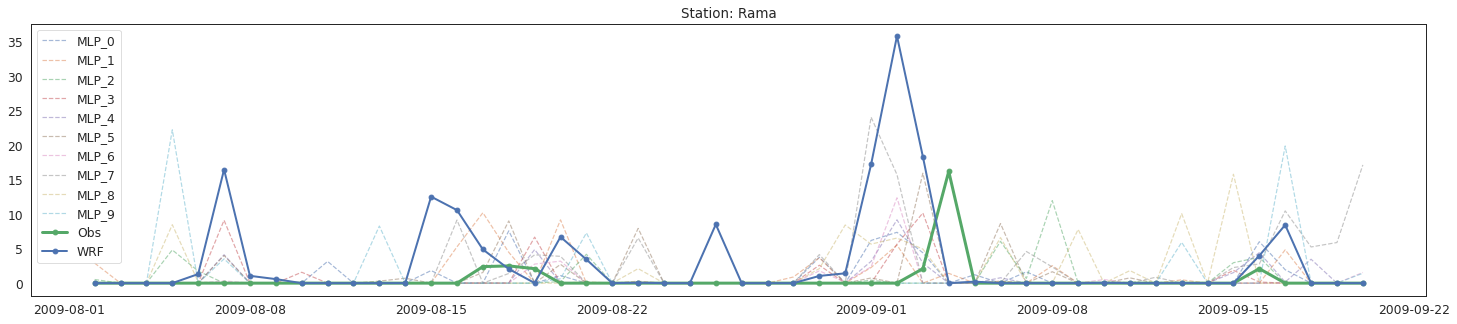

In [186]:
plt.figure(figsize=(25,5))
for i in range(10):
    x3 = df[f'sample_{i:.0f}']
    plt.plot(x0, x3, '--', label=f'MLP_{i}', alpha=.5)

plt.plot(x0, x1, '-og', label='Obs', linewidth=3)
plt.plot(x0, x2, '-ob', label='WRF', linewidth=2)

plt.legend()
plt.title(f"Station: {s}")
plt.show()

## QQ plots

In [158]:
# predictions['MLP_[10]_bgmm_B=128_D=0']['k_all'].describe()
len(predictions['MLP_[10]_bgmm_B=128_D=0']['k_all']['Station'].unique())

12

In [140]:
df = predictions['MLP_[10]_bgmm_B=128_D=0']['k_all']

In [11]:
from scipy import stats

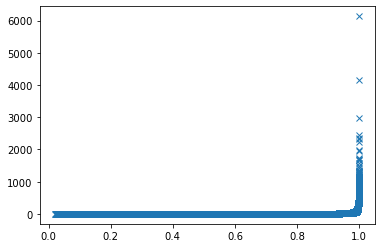

In [75]:
plt.plot(df['pi'], abs(0.1 - df['pi']) / (1 - df['pi']),'x')

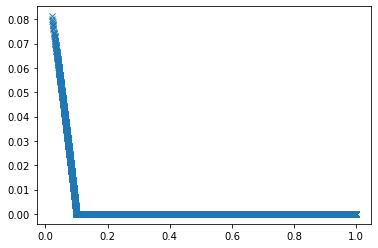

In [81]:
plt.plot(df['pi'], (df['pi'].to_numpy() < q).astype('int') * abs(q - df['pi']) / (1 - df['pi']), 'x')

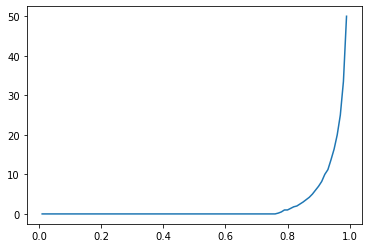

In [155]:
plt.plot(np.arange(0.01,1,0.01), np.quantile(df['Prec'], np.arange(0.01,1,0.01)))

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

0.01 0.0
0.06157894736842105 0.0001342823066133893
0.1131578947368421 0.00182167773911578
0.16473684210526315 0.00734442037232891
0.2163157894736842 0.01934980886655249
0.26789473684210524 0.04289400175467132
0.3194736842105263 0.08516445590633971
0.37105263157894736 0.1555352024639679
0.4226315789473684 0.26556321275425776
0.47421052631578947 0.42992943618927454
0.5257894736842105 0.6647175973440576
0.5773684210526315 0.9887213246713903
0.6289473684210526 1.4250175762957555
0.6805263157894736 2.0053949511637787
0.7321052631578947 2.778702237130235
0.7836842105263158 3.8274741531790344
0.8352631578947368 5.310420825544775
0.8868421052631579 7.580047343163449
0.9384210526315789 11.72077852329442
0.99 26.796454932684068


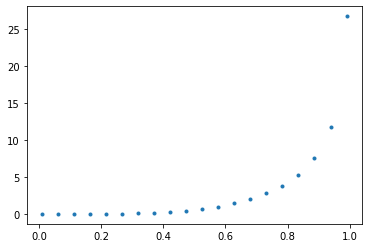

In [144]:
ys = []
qs = np.linspace(0.01,0.99,20)
for q in qs:
    y = (q > df['pi'].to_numpy()).astype('int') * stats.gamma.ppf(q=(q - df['pi'])/(1-df['pi']), a=df['alpha'].to_numpy(), loc=0, scale=1/df['beta'].to_numpy())
    # x = 1 - df['pi']
    y = np.nan_to_num(y).mean()
    print(q, y)
    ys.append(y)

plt.plot(qs, ys,'.')

In [137]:
q = 0.01
y = (q > df['pi'].to_numpy()).astype('int') * stats.gamma.ppf(q=(q - df['pi'])/(1-df['pi']), a=df['alpha'].to_numpy(), loc=0, scale=1/df['beta'].to_numpy())
y

array([nan, nan, nan, ..., nan, nan, nan])

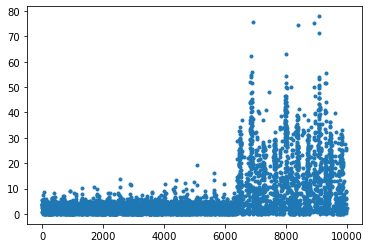

In [119]:
plt.plot(y[:10000],'.')

In [19]:
%%time
q = 0.1


x = 

CPU times: user 365 ms, sys: 1.94 ms, total: 367 ms
Wall time: 367 ms


array([0.03768449, 0.0393385 , 0.04203768, ..., 0.01461151, 0.02056658,
       0.01915252])

0 Ghanauli
1 Lohard
2 Bharatgarh
3 Ganguwal
4 Kotata
5 Olinda
6 Paonta Sahib
7 Dhaula Kuan
8 Nangal
9 Dehra
10 Nadaun
11 Sujanpur
12 Bhakra
13 Sadar-Bilarspur
14 Naina Devi
15 Berthin
16 Dadahu
17 Ghumarwin
18 Rakuna
19 Kasol
20 Kangra
21 Sadar-Mandi
22 Hamirpur
23 SuniIMD
24 Daslehra
25 Bhoranj
26 Suni
27 Nahan
28 Sundernagar
29 RampurIMD
30 Pandoh
31 Larji
32 Rampur
33 Bhuntar
34 Sarkaghat
35 Arki
36 Swaghat
37 Pachhad
38 Palampur
39 Sainj
40 Banjar
41 Kandaghat
42 Churah
43 Karsog
44 Tipping Bucket Syafrubesi
45 BanjarIMD
46 Jogindernagar
47 Gilgit
48 Kothai
49 Rohru
50 Kumarsain
51 Salooni
52 Bharmaur
53 Janjehl
54 Theog
55 Jubbal
56 Mashobra
57 Kalatop
58 Tipping Bucket Lama Hotel
59 Shigar
60 Kalpa
61 Naltar
62 Rattu
63 Hushey
64 Rama
65 Ushkore
66 Yasin
67 Tipping Bucket Langtang
68 Kaza
69 Ziarat
70 Shendure
71 Tipping Bucket Kyanjing
72 AWS Kyangjing
73 Tipping Bucket Jathang
74 Deosai
75 Tipping Bucket Numthang old
76 Tipping Bucket Ganja La 1
77 Tipping Bucket Langshisha BC


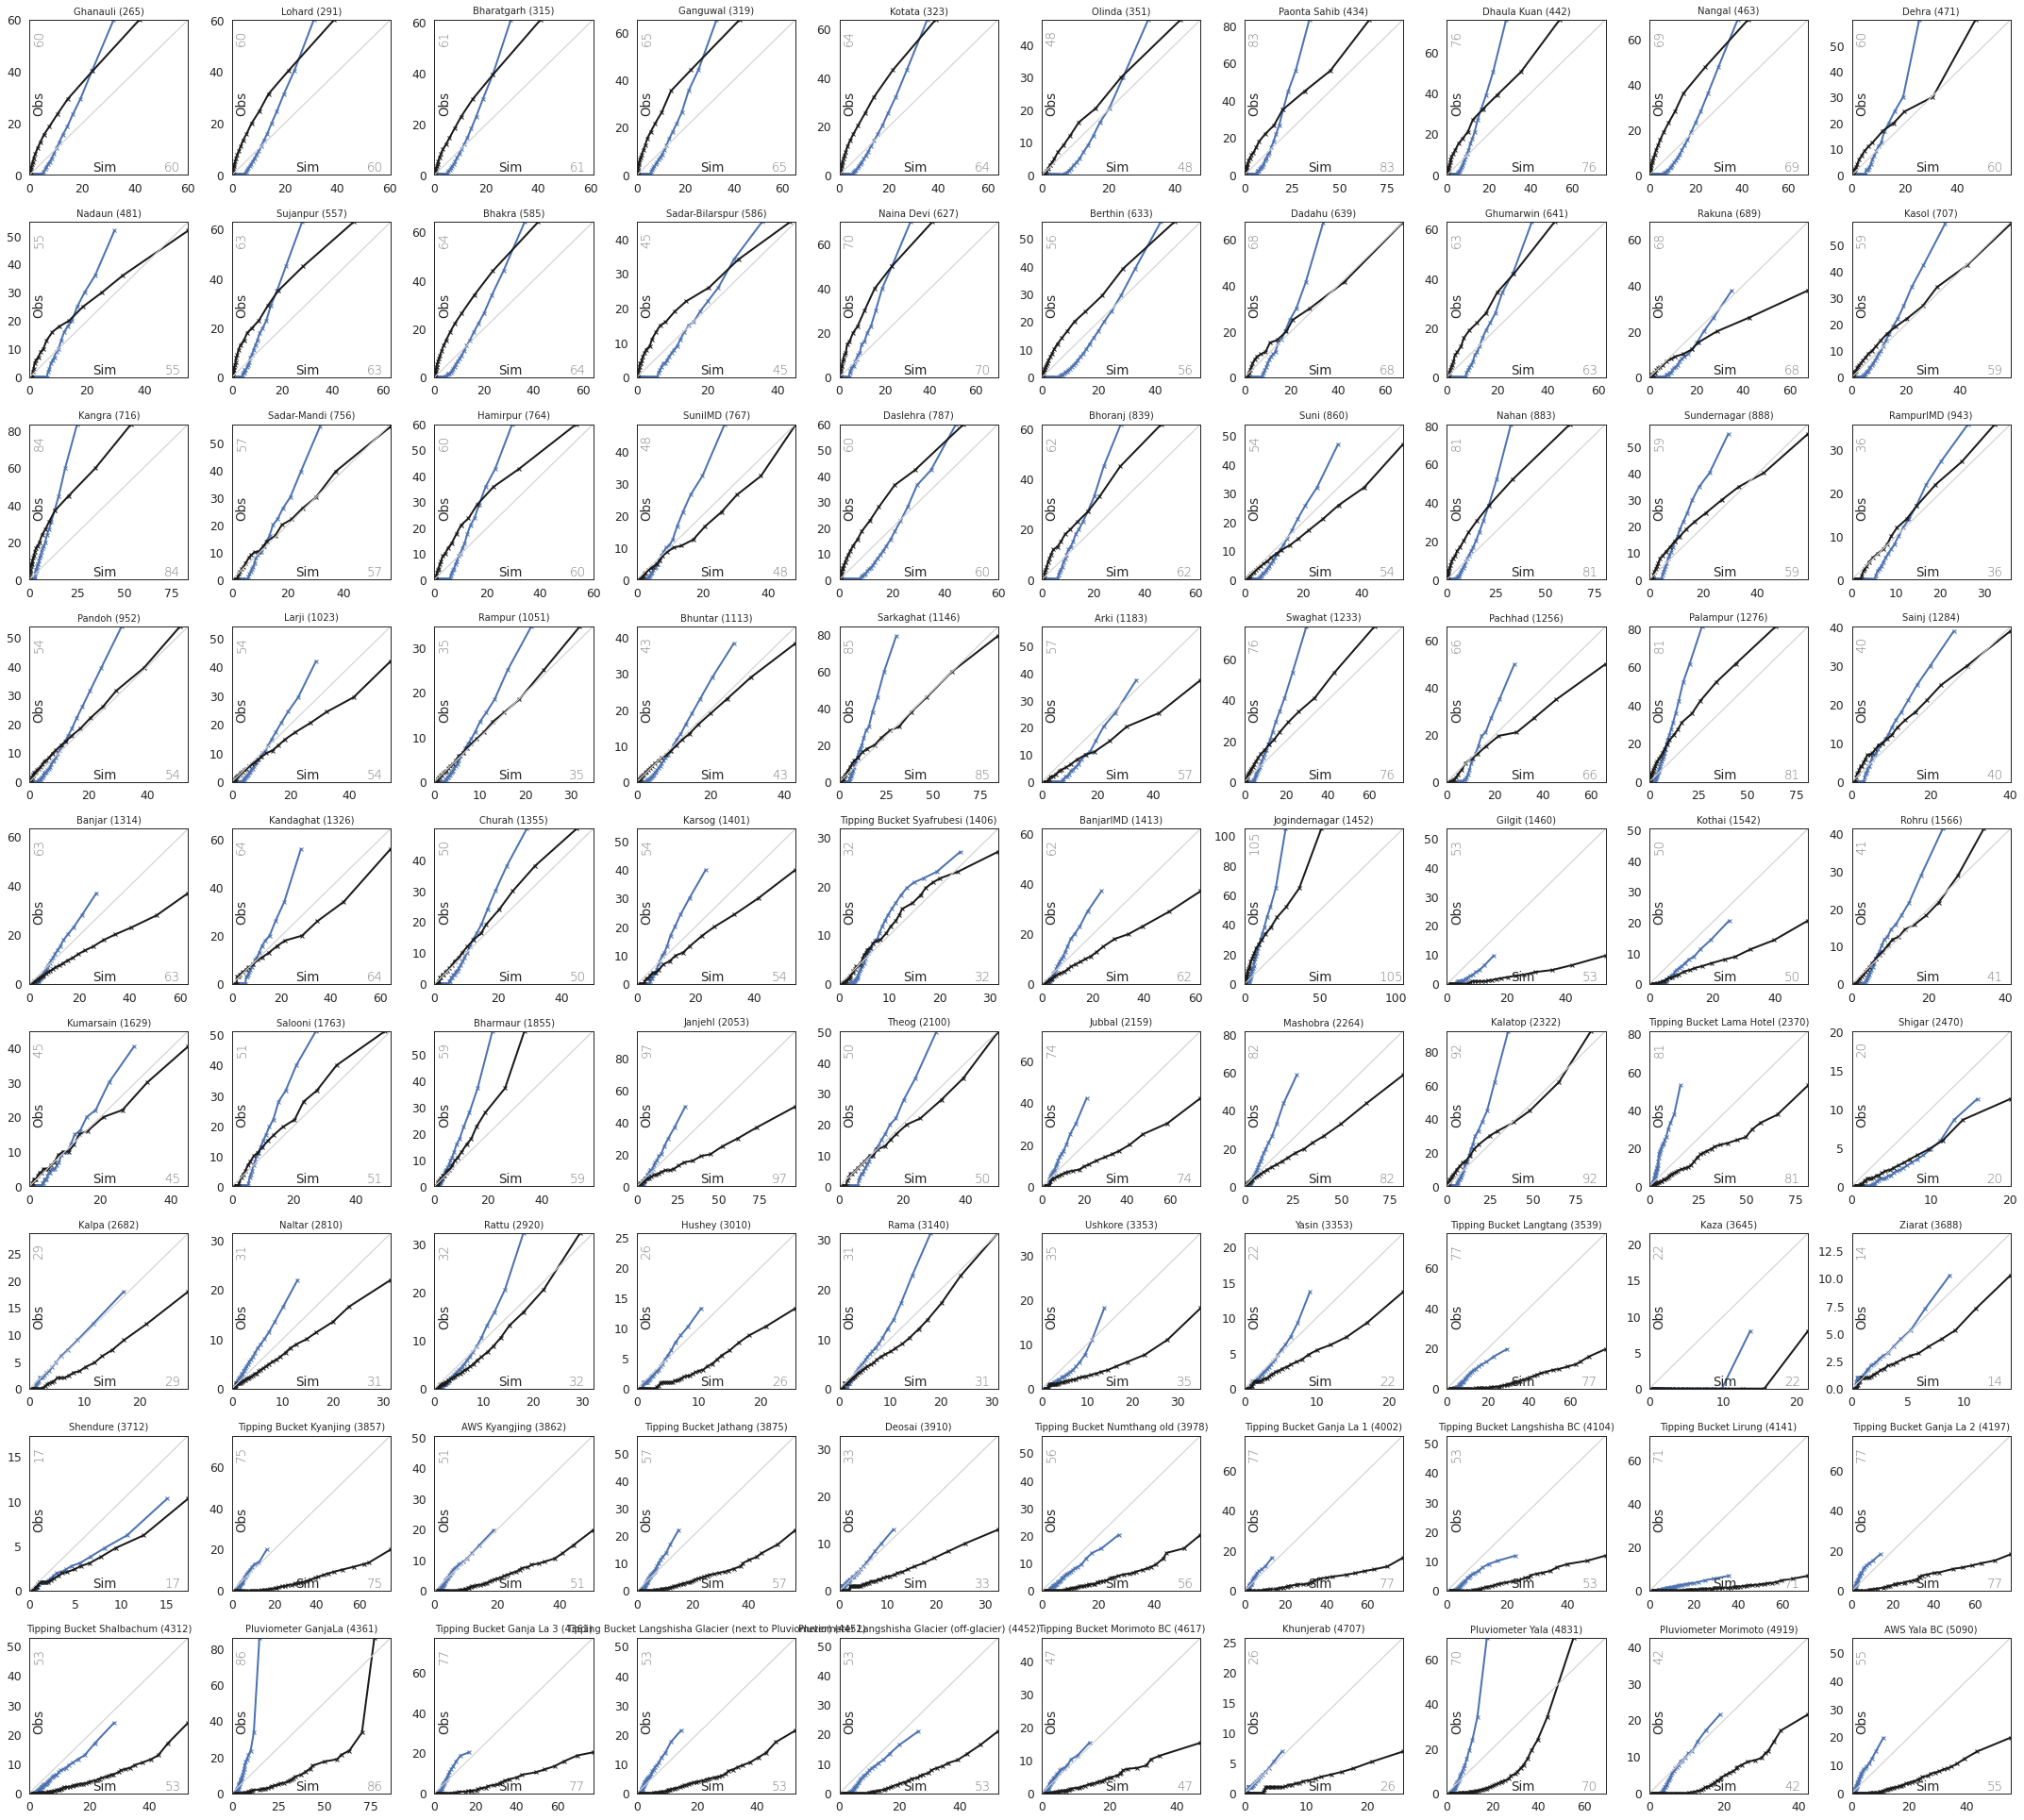

In [159]:
plot_qq_for_all_stations(predictions['MLP_[10]_bgmm_B=128_D=0']['k_all'], n_rows=9, n_cols=10, 
                         sim='precip_norris', obs='Prec', mod='sample_0', plot_all_samples=True)

## [OLD] Seasonal analysis 

In [26]:
sample_cols = [f'sample_{i}' for i in range(CONFIG.n_samples)]
add_cols = []
columns = ['Prec','wrf_prcp','wrf_bc_prcp','precip_norris']

In [27]:
for p in predictions.keys(): 
    for k,v in predictions[p].items():
        v['wrf_prcp'] = v['precip_norris'] 
        v['wrf_bc_prcp'] = v['precip_norris'] 

In [28]:
for k,v in predictions.items():
    print(f"{k : <40} {v['k_all'].BS.mean():.3f}")

VGLM_[]_bgmm_B=128_D=0                   0.573
MLP_[10]_bgmm_B=128_D=0                  0.585
SimpleRNN_[10]_bgmm_B=128_D=0            0.422
MLP_[50, 50]_bgmm_B=128_D=0              0.593
SimpleRNN_[50, 50]_bgmm_B=128_D=0        0.421


In [150]:
# table_of_predictions_ks_test(predictions, CONFIG.seasons, columns, sample_cols, add_cols)

In [151]:
# table_of_predictions_for_metric(predictions, CONFIG.seasons, columns, CONFIG.n_samples, sample_cols, add_cols, metric = 'smape', prefix='smape')

In [152]:
# table_of_predictions_for_metric(predictions, CONFIG.seasons, columns, CONFIG.n_samples, sample_cols, add_cols, metric = 'edd', prefix='edd')

In [153]:
# table_of_predictions_for_metric(predictions, CONFIG.seasons, columns, CONFIG.n_samples, sample_cols, add_cols, metric = 'ae', prefix='ae')

In [289]:
predictions['MLP_[10]_bgmm_B=128_D=0']['k_all'].Region

84394     WestUIB
84395     WestUIB
84396     WestUIB
84397     WestUIB
84398     WestUIB
           ...   
272607    EastUIB
272608    EastUIB
272609    EastUIB
272610    EastUIB
272611    EastUIB
Name: Region, Length: 456725, dtype: object

In [ ]:
regions = predictions['MLP_[10]_bgmm_B=128_D=0']['k_all'].Region.unique()
plt.figure(figsize=(12,5))

for r in regions:
    
    df = predictions['MLP_[10]_bgmm_B=128_D=0']['k_all'].copy()
    
    x = df[df.Region==r].groupby('Station').mean()['k_fold'].to_numpy()
    y = df[df.Region==r].groupby('Station').mean()['Z'].to_numpy()
    
    plt.plot(x,y,'o', markersize=6, label=r)
    
plt.legend()
plt.grid()
plt.xticks(np.arange(10))
plt.ylabel('Elevation (m.a.s.l.)')
plt.xlabel('k-fold held out set')
plt.show()

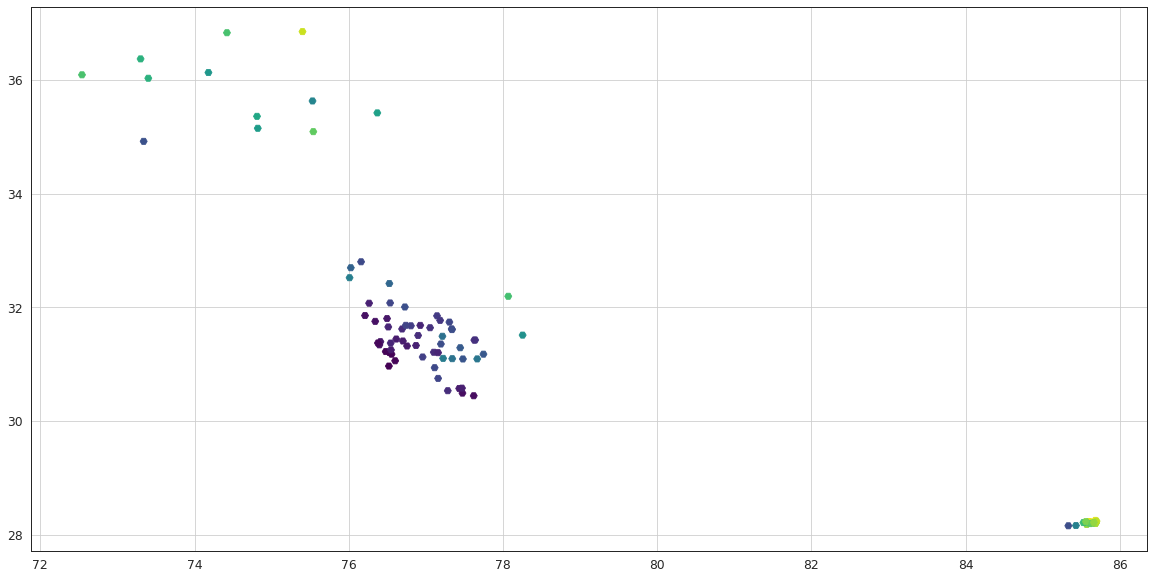

In [325]:
df = predictions['MLP_[10]_bgmm_B=128_D=0']['k_all'].copy()

plt.figure(figsize=(20, 10))

x = df.groupby('Station').agg('first')['X']
y = df.groupby('Station').mean()['Y']
z = df.groupby('Station').mean()['Z']
c = df.groupby('Station').agg('first')['k_fold']

plt.scatter(x,y,c=z,s=50,cmap='viridis', marker='H')
plt.grid()
plt.show()